In [1]:
import os
import pandas as pd
from wordcloud import WordCloud
import numpy as np
import collections
import re
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation  
from string import digits
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# use if required
#!pip install contractions
import contractions
import matplotlib.pyplot as plt

     |████████████████████████████████| 327kB 4.3MB/s 
     |████████████████████████████████| 286kB 6.4MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85397 sha256=1cd2df0878f35b292afe119d5de4db6be1b1c6cfc25dda4f1c498d0c822ddf0d
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [2]:
# Use only when using colab to mount the drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
#Preprocessing
#Use these if required.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# create a lemmatizer object
lemmatizer = nltk.stem.WordNetLemmatizer()
# create an object to remove punctuation marks
puncutation_translator = str.maketrans('', '', punctuation)
digit_translator = str.maketrans('', '', digits)
# create a stop word list (*** Check if negation words need to be eliminated from the list ***)
stopwords_list = set(stopwords.words('english') + list(punctuation) + ['ATUSER','URL'])

## function for pre-preocessing individual tweet
## 1. Changing it into lowercase
## 2. Fixing contractions. For e.g. can't -> can not
## 3. Removing URLs
## 4. Removing usernames.
## 5. Removing Punctutation marks.
## 6. Removing digits.
## 7. Tokenizing sentences into words.
## 8. Lemmatization of each word assuming it's POS tag as verb.
## 9. Removing stop words.
def preProcessTweet(tweet_elm):
  tweet = tweet_elm.lower()
  tweet = contractions.fix(tweet)
  tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet)
  tweet = re.sub('@[^\s]+', 'ATUSER', tweet)
  tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
  tweet = tweet.translate(puncutation_translator)
  tweet = tweet.translate(digit_translator)
  tweet = word_tokenize(tweet)
  return " ".join([lemmatizer.lemmatize(word, 'v') for word in tweet if word not in stopwords_list])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
# extract vaccine dataset
dataFrame_vaccine_trend = pd.read_csv("/content/drive/My Drive/study/data_analytics/project/src/covid_data/covidvaccine.csv", encoding = "utf8") 
dataFrame_vaccine_trend.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64.0,11,110,FALSE,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and ...,['CovidVaccine'],Twitter Web App,False
1,Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1.0,17,0,FALSE,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,False
2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143.0,566,8,FALSE,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\n...,NaN,Twitter Web App,False
3,Zane,NaN,Fresher than you.,18-09-2019 11:01,29.0,25,620,FALSE,18-08-2020 12:45,@Team_Subhashree @subhashreesotwe @iamrajchoco...,NaN,Twitter for Android,False
4,Ann-Maree O’Connor,"Adelaide, South Australia",Retired university administrator. Melburnian b...,24-01-2013 14:53,83.0,497,10737,FALSE,18-08-2020 12:45,@michellegrattan @ConversationEDU This is what...,NaN,Twitter Web App,False


In [5]:
# extract tweets
user_verified = dataFrame_vaccine_trend.iloc[:, 7].to_numpy()
tweets_vaccine = dataFrame_vaccine_trend.iloc[:, 9].to_numpy()

In [6]:
# Process tweets
processed_tweets_vaccine = []
for tweet in tweets_vaccine:
  try:
    processed_tweets_vaccine.append(preProcessTweet(tweet))
  except:
    processed_tweets_vaccine.append(tweet)

In [7]:
## VADER Analysis (Install only if required)
#!pip install twython
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [8]:
# Vader Analyzer oObject
vaderSentimentAnalyzer = SentimentIntensityAnalyzer()

tweet_sentiment_vader = []
neg_sentiment = 0
pos_sentiment = 0
neu_sentiment = 0

for tweet in processed_tweets_vaccine:
  try:
    score = vaderSentimentAnalyzer.polarity_scores(tweet)
    sentiment = score['compound']
    
    if (sentiment < 0):
      neg_sentiment += 1
      tweet_sentiment_vader.append("negative")
    elif (sentiment > 0):
      pos_sentiment += 1
      tweet_sentiment_vader.append("positive")
    elif (sentiment == 0):
      neu_sentiment += 1
      tweet_sentiment_vader.append("neutral")
  except:
    tweet_sentiment_vader.append("positive")

In [9]:
# Exttract tweets from verified users only.
tweet_sentiment_vader = np.array(tweet_sentiment_vader)
TRUE_indices = np.where(user_verified == "TRUE")[0]
true_indices = np.where(user_verified == True)[0]
indices = np.concatenate((TRUE_indices, true_indices))

verified_user_tweet_sentiment_dict = collections.Counter(tweet_sentiment_vader[indices])
print(verified_user_tweet_sentiment_dict)

Counter({'positive': 8858, 'neutral': 8022, 'negative': 2910})


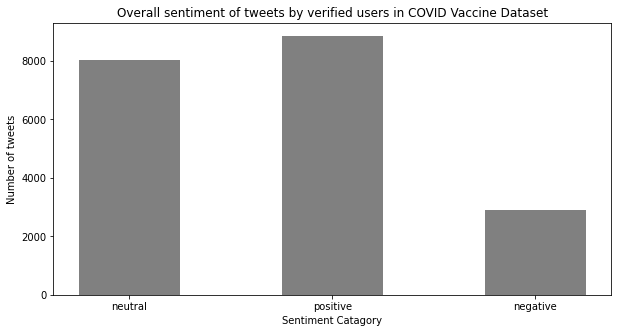

In [11]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(list(verified_user_tweet_sentiment_dict.keys()), list(verified_user_tweet_sentiment_dict.values()), color ='grey', width = 0.5)
 
plt.xlabel("Sentiment Catagory")
plt.ylabel("Number of tweets")
plt.title("Overall sentiment of tweets by verified users in COVID Vaccine Dataset")
plt.show()